# 3. Hands-on experiment 2: k-means Clustering by Semidefinite Programming

Clustering is an unsupervised machine learning problem in which we try to partition a given data set into $k$ subsets based on distance between data points or similarity among them. The goal is to find $k$ centers and to assign each data point to one of the centers such that the sum of the square distances between them are minimal [1]. This problem is known to be NP-hard. 

### Clustering problem
Given a set of $n$ points in a $d-$dimensional Euclidean space, denoted by
\begin{equation*}
S = \{ \mathbf{s}_i = (s_{i1}, \cdots, s_{id})^\top~\in \mathbb{R}^d ~~ i = 1, \cdots, n\}
\end{equation*}
find an assignment of the $n$ points into $k$ disjoint clusters $\mathcal{S} = (S_1, \cdots, S_k)$ whose centers are $\mathbf{c}_j(j = 1, \cdots, k)$ based on the total sum of squared Euclidean distances from each point $\mathbf{s}_i$ to its assigned cluster centroid $\mathbf{c}_i$, i.e.,
\begin{equation}
f(S,\mathcal{S}) = \sum_{j=1}^k\sum_{i=1}^{|S_j|}\|\mathbf{s}_i^{j} - \mathbf{c}_j \|^2,
\label{eq:kmeans}\tag{1}
\end{equation}
where $|S_j|$ is the number of points in $S_j$, and $\mathbf{s}_i^{j} $ is the $i^{th}$ point in $S_j$.


### Relaxation of the problem
[1] proposes an SDP-relaxation to approximately solve the abovementioned model-free $k-$means clustering problem.
The resulting optimization problem (See section (2) of [1] for details of this relaxation) takes the standard semidefinite programming form 

\begin{equation}
\mathbf{X^\star} \in \arg \min_{ \mathbf{X} } \bigg\{ \text{Tr}(\mathbf{CX}) : ~\underbrace{\mathbf{X} \mathbf{1} =  \mathbf{1}}_{A_1(\mathbf{X}) = b}, ~\underbrace{\mathbf{X}^\top \mathbf{1} =  \mathbf{1}}_{A_2(\mathbf{X}) = b},~\underbrace{\mathbf{X}\geq 0}_{\mathbf{X} \in \mathcal{K}},~\underbrace{\mathrm{Tr}(\mathbf{X}) \leq \kappa, ~\mathbf{X} \in \mathbb{R}^{p\times p} ,~\mathbf{X}\succeq 0 }_{\mathcal{X}} \bigg\}, \label{eq:cluster_sdp}\tag{2}
\end{equation}
where $C \in \mathbb{R}^{p \times p}$ is the Euclidean distance matrix between the data points. 
$\mathrm{Tr}( \mathbf{X}) \leq \kappa$ enforces approximately low-rank solutions, the linear inclusion constraint $\mathbf{X} \geq 0 $ is element-wise nonnegativity of ${\mathbf{X}}$, the linear equality constraints $ \mathbf{X}\mathbf{1} = \mathbf{1}$ and $ \mathbf{X}^{\top} \mathbf{1} = \mathbf{1}$ require row and column sums of $ \mathbf{X}$ to be equal to 1's, and $ \mathbf{X} \succeq 0$ means that $ \mathbf{X}$ is positive semi-definite. 

Recall that $\mathrm{Tr}( \mathbf{X}) = \| \mathbf{X}\|_\ast$ for any positive semi-definite matrix $ \mathbf{X}$.


### Algorithm

Program \eqref{eq:cluster_sdp} can be reformulated as

\begin{equation}
\begin{aligned}
&\min_{\mathbf{X} \in \mathcal{X}}  f(\mathbf{X}) + g_1(A_1(\mathbf{X})) + g_1(A_2(\mathbf{X}))\\
&\text{subject to }  B(\mathbf{X}) \in \mathcal{K}
\end{aligned}\label{eq:hcg}\tag{3}
\end{equation}
where $f(x) = \text{Tr}(\mathbf{CX}) $  is a smooth convex function,  $g$ is the indicator function of the singleton $\{\mathbf{b}\}$ and ${\mathcal{K}}$ is the positive orthant (i.e. the set $\mathcal{K} = \{\mathbf{X} \in \mathbb{R}^{p\times p}: \mathbf{X} \geq 0\}$) for which computing the projection is easy. This means that we can do simple gradient updates on this part of the problem. To account for the constraint set $\mathcal{x}$, we can rely on the powerful linear minimization oracle to tackle the fact that $\mathbf{X} \in \mathcal{X}$ without requiring projections. Recall that the linear minimization oracle (LMO) is defined as follows
 \begin{equation*}
\text{lmo}_{\mathcal{X}}(\mathbf{Z})  = \arg \min_{\mathbf{X} \in \mathcal{X}} \langle \mathbf{X},\mathbf{Z} \rangle \qquad \text{where}\qquad \langle \mathbf{X},\mathbf{Z} \rangle = \text{Tr}(\mathbf{Z}^\top\mathbf{X}).
\end{equation*}
One of the main advantages of leveraging LMOs is to avoid doing costly projection operations, which explains the increasing popularity of this method (e.g. [2,5]). Indeed, in this setting, projecting onto $\mathcal{X}$ would require computing a full singular value decomposition (SVD), a very expensive operation.


Note that the classical Frank-Wolfe method does not apply to this problem due to nonsmooth term $g$. 
In the sequel, we will attempt to solve this problem with the HomotopyCGM method proposed in [2] to handle the non-smooth problems with a conditional gradient based method. This approach reformulates the problem using smoothing and homotopy, which in term leads to the gradient expression found at the second line of the algorithm below. The details of the transformation can be found in [2]. The full Homotopy CGM algorithm to solve  \eqref{eq:hcg} is stated just below.


---
**Conditional Gradient Method(CGM) for composite problems**

---
$\textbf{1.}~ \text{Choose } \mathbf{X}_0 \in\mathcal{X}$ and $\beta_0 >  0$ 

$\textbf{2.}~\text{For } k=1, 2, \ldots$  perform: 
\begin{equation*}
\begin{cases}
\gamma_k &= 2/(k+1), ~\text{and}~ \beta_k = \beta_0 / \sqrt{k+1} \\
\mathbf{V}_k &= \beta_k \nabla f(\mathbf{X}_k) + A_1^\top (A_1(\mathbf{X}_k) - \mathbf{b}_1) + A_2^\top (A_2(\mathbf{X}_k) - \mathbf{b}_2) + (\mathbf{X}_k - \text{proj}_{\mathcal{K}}(\mathbf{X}_k))\\
\hat{\mathbf{X}}_k &:= \mathrm{argmin}_{x \in \mathcal{X}} \left \langle  \mathbf{V}_k,  \mathbf{X} \right \rangle \\
\mathbf{X}_{k+1} &:= (1-\gamma_k)\mathbf{X}_k + \gamma_k\hat{\mathbf{X}}_k
\end{cases}
\end{equation*} 
$\textbf{3.}~ \text{Output:} ~ \mathbf{X}_k$ 

---

### 3. Dataset:
    
We use a similar setup described by [3]. We use the fashion-MNIST data in [4] which is released as a possible replacement for the MNIST handwritten digits. Each data point is a 28x28 grayscale image, associated with a label from 10 classes. The figure below depicts 3 row samples from each class. Classes are labeled from 0 to 9. 

First, we extract the meaningful features from this dataset using a simple 2 layers neural network with a sigmoid activation. Then, we apply neural network to 1000 test samples from the same dataset, which gives us a vector $\mu \in \mathbb{R}^{10}$ where each entry represents the probability being in that class. 
Then, we form the pairwise distance matrix $\boldsymbol{C}$ by using this probability vectors.

**N.B.** In the code, you do not need to worry about any of the processing details mentioned here. You are directly given the matrix $\mathbf{C}$.


![Fashion-MNIST example](fig/fashion-mnist-sprite.png)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigsh, svds, eigs
from math import sqrt
import scipy.io as sio
import random
import numpy.matlib
from helpers import *
# fix the seed
random.seed( 3 )

In [2]:
# Load data
Problem = sio.loadmat('data/clustering_data.mat')
C = np.double(Problem['C']) # euclidean distance matrix
N = np.int(Problem['N']) # number of data points
k = Problem['k'] # number of clusters
opt_val = Problem['opt_val'] # optimum value 
images = Problem['images'] # images for visualization after clustering
labels = Problem['labels'] # true labels
digits = Problem['digits'] # input data points

### Problem 3.1 Conditional gradient method for clustering fashion-mnist Data

---
#### <span style="font-variant:small-caps;">(a) *(10 points)*</span>
Show that the domain $\mathcal{X} = \{\mathbf{X}: \mathrm{Tr}(\mathbf{X}) \leq \kappa,~\mathbf{X} \in \mathbb{C}^{p\times p} ,~\mathbf{X} \succeq 0\}$ is a convex set. 

<span style="font-variant:small-caps;">Recall:</span> $\mathcal{X}$ is a convex set if and only if for any $\mathbf{X},\mathbf{Y} \in \mathcal{X}$ and $\alpha \in [0,1]$, $$\alpha\mathbf{X} + (1-\alpha)\mathbf{Y} \in \mathcal{X}$$



---
#### <span style="font-variant:small-caps;">(b) *(10 points)*</span>
Given a linear inclusion constraint $T\mathbf{X} \in \mathcal{Y}$, the corresponding quadratic penalty function is given by
$$
\text{QP}_\mathcal{Y}(x) = \text{dist}^2(T\mathbf{X}, \mathcal{Y}) = \min_{y \in \mathcal{Y}} \| y-T\mathbf{X}\|^2.
$$
Write down the constraints in equation (1) in the quadratic penalty form and **show that** the penalized objective takes the form
$$
f(\mathbf{X}) + \frac{1}{2\beta} \|A_1(\mathbf{X}) - b_1\|^2 + \frac{1}{2\beta} \|A_2(\mathbf{X}) - b_2\|^2 + \frac{1}{2\beta}\text{dist}^2(T\mathbf{X}, \mathcal{K}), 
$$
and **show that** the gradient of the penalized objective is equal to ${v_k/}{\beta}$ in the algorithm.

<span style="font-variant:small-caps;"> Hint: </span> You can write $\text{dist}^2(T\mathbf{X}, \mathcal{Y}) = \| y^\ast - T\mathbf{X} \|^2$, where $y^\ast = \arg \min _{y\in \mathcal{Y}} \| y - T\mathbf{X} \|^2$, and take the derivative with respect to $\mathbf{X}$ without worrying about $y^\ast$ depending on $\mathbf{X}$, thanks to [Danskin's theorem](https://en.wikipedia.org/wiki/Danskin%27s_theorem). 

---
#### <span style="font-variant:small-caps;">(c) *(5 points)*</span>

Write down $v_k$ explicitly by deriving the gradient and projection specific to problem (3).

---
#### <span style="font-variant:small-caps;">(d) *(20 points)*</span>

Complete the missing lines in the function definition of `HomotopyCGM`, and run the code after it to solve the $k$-means clustering problem. Using the function `value_kmeans`, compute  and report the k-means value as expressed in (1), before and after running the algorithm. Visualize the results and SDP solution $\mathbf{X}$ after $5000$ iterations using the provided function `plot_func`. What is the final objective value? Is it below the optimal value provided to you? If yes, explain the reason. 

(<span style="font-variant:small-caps;"> Hint: </span> Note that when $\mathcal{X}$ is as given in equation (2), $\kappa u u^\top \in \text{lmo}_{\mathcal{X}}(X)$, where $u$ is the eigenvector corresponding to the smallest eigenvalue of $X$.)

---

### Define operators
We provide 2 operators and their conjugates:
1. `A1`: Linear operator that takes the row sums
2. `At2`: Conjugate of operator A1
3. `A2`: Linear operator that takes the column sums 
4. `At2`: Conjugate of operator A2

In [3]:
A1 = lambda x: np.sum(x, axis = 1)
At1 = lambda y: np.transpose(np.matlib.repmat(y, N, 1))
A2 = lambda x: np.sum(x, axis = 0)
At2 = lambda y: (np.matlib.repmat(y, N, 1))

b = np.double(np.ones(N))

In [4]:
# Plotting function
def plot_func(cur_iter, feasibility1,feasibility2, objective, X):
    plt.figure(figsize=(12, 8))
    plt.subplot(221)
    plt.loglog(cur_iter, feasibility1)#, 'go--', linewidth=2, markersize=12))
    plt.xlabel('iteration',fontsize=15)
    plt.ylabel('$\|X1-1\|/1$',fontsize=15)
    plt.grid(True)

    plt.subplot(222)
    plt.loglog(cur_iter, feasibility2)
    plt.xlabel('iteration',fontsize=15)
    plt.ylabel('dist$(X, \mathbb{R}^{n}_+)$',fontsize=15)
    plt.grid(True)
    plt.show()

    #plt.subplot(223)
    obj_res = np.reshape(np.abs(objective - opt_val)/opt_val, (len(objective),))
    plt.figure(figsize=(12, 8))
    plt.loglog((cur_iter), (obj_res))
    plt.xlabel('iteration',fontsize=15)
    plt.ylabel('$(f(X) - f^*)/f^*$',fontsize=15)
    plt.title('Relative objective residual',fontsize=15)
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(12, 8))
    plt.imshow(X)
    plt.title('SDP solution',fontsize=15)
    plt.show()

In [5]:
def HomotopyCGM(kappa=10, maxit=np.int(1e3), beta0=1):
    # Initialize
    X = np.zeros((N,N))
    AX1_b = 0.0
    
    feasibility1 = [] # norm(A1(X)-b1)/norm(b1)
    feasibility2 = [] # dist(X, \mathcal{K})
    objective    = [] # f(x)
    cur_iter     = [] 
    
    #u = np.zeros((N,1))
    iter_track = np.unique(np.ceil(np.power(2, np.linspace(0,20,50))))
    
    for iteration in range(1, maxit+1):
        
        # Update Step Size
        gamma = 2 / (iteration + 1)
        
        # Update beta
        beta_ = beta0 / np.sqrt(iteration + 1)
        
        # Write down the vk to use in the lmo (eigenvalue routine)
        vk = beta_ * C + At1(A1(X) - b) + At2(A2(X) - b) + 1000 * np.minimum(X, 0)
        vk = 0.5*(vk + vk.T) # This step is just to make sure vk is symmetric
        
        # Linear minimization oracle
        q, u = eigsh(vk , k=1, tol=1e-16, which='SA') # 'SA' option computes the smallest algebraic eigenvector. 
        u = sqrt(kappa)*u
        X_bar = np.outer(u,u)
        
        # Obtain A*Xbar - b
        AX_bar_b = A1(X_bar)-b
        
        # Update A*X - b
        AX1_b = (1.0-gamma)*AX1_b + gamma*(AX_bar_b)
        
        # Update X
        X = (1 - gamma) * X + gamma * X_bar
                
        if any(iteration == iter_track) or iteration==maxit:
            feasibility1.append(np.linalg.norm(AX1_b)/N)
            feasibility2.append(np.linalg.norm(np.minimum(X,0), ord='fro'))
            objective.append(np.sum(C.flatten()*X.flatten()))
            cur_iter.append(iteration)
            print('{:03d} | {:.4e}| {:.4e}| {:.4e}|'.format(iteration, feasibility1[-1], feasibility2[-1],objective[-1]))
            
    return X, feasibility1, feasibility2, objective, cur_iter

### Run the algorithm

In [6]:
X, feasibility1, feasibility2, objective, cur_iter = HomotopyCGM(10, np.int(5e3), 1)

001 | 2.8157e-01| 0.0000e+00| 1.5028e+04|
002 | 7.2775e-02| 2.8124e+00| 4.0633e+03|
003 | 3.8797e-02| 2.8820e+00| 1.7951e+03|
004 | 6.0178e-02| 1.6950e+00| 2.1542e+03|
005 | 4.4115e-02| 1.8916e+00| 2.3621e+03|
006 | 3.9321e-02| 1.3341e+00| 2.1423e+03|
008 | 3.1495e-02| 1.3564e+00| 1.9023e+03|
010 | 2.7986e-02| 1.0876e+00| 1.7042e+03|
013 | 9.1450e-03| 1.1454e+00| 8.7334e+02|
017 | 9.7534e-03| 8.7930e-01| 8.0521e+02|
023 | 1.0672e-02| 6.6643e-01| 8.7141e+02|
030 | 7.5734e-03| 4.7975e-01| 7.2881e+02|
040 | 7.0140e-03| 3.3010e-01| 6.7838e+02|
053 | 4.0745e-03| 3.2327e-01| 5.9426e+02|
070 | 3.7770e-03| 2.4258e-01| 5.2277e+02|
093 | 2.7295e-03| 2.1481e-01| 4.9279e+02|
123 | 3.1140e-03| 1.7212e-01| 4.5223e+02|
163 | 1.8561e-03| 1.6561e-01| 4.0424e+02|
217 | 1.7107e-03| 1.1395e-01| 4.4667e+02|
287 | 9.5906e-04| 6.9516e-02| 4.8307e+02|
381 | 1.1298e-03| 6.1610e-02| 4.3712e+02|
505 | 8.1979e-04| 5.1524e-02| 3.8387e+02|
670 | 6.8797e-04| 3.9665e-02| 3.1293e+02|
889 | 6.0843e-04| 3.5165e-02| 2.47

### Visualize the results

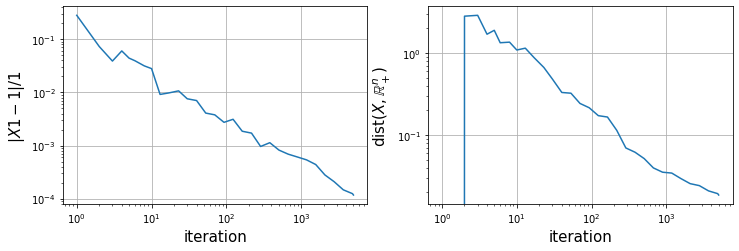

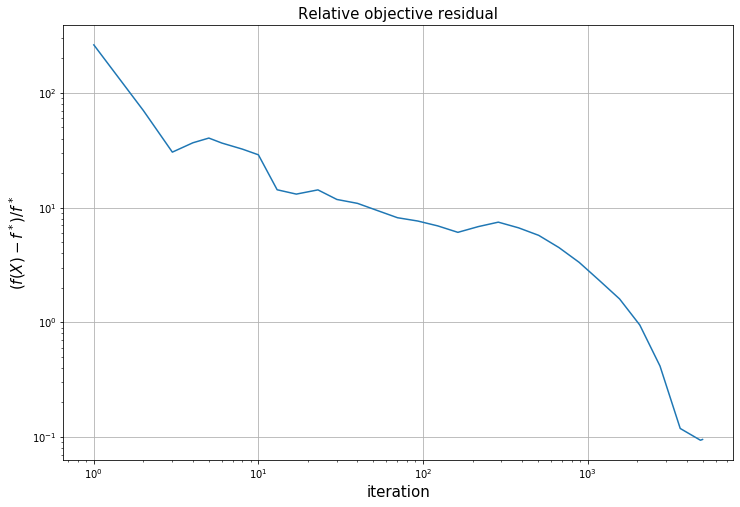

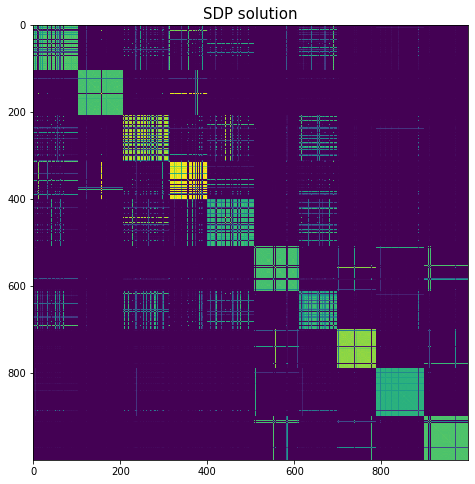

In [7]:
plot_func(cur_iter, feasibility1,feasibility2, objective, X)

### Get the assignments from the result of the SDP
Getting the assignments requires going back to the $10$ dimensional space discussed before, and using the coordinates multiplied with the obtained matrix to construct a "denoised" version of the data points. This allows then to find the clusters from these $10$ dimensional data. See [3] for more details. Our implementation is the python reimplementation of their matlab code which can be found on [github](https://github.com/solevillar/kmeans_sdp).

In [8]:
center_CGM,assign_CGM = sdp_rounding(X,10, digits)

### k-means value and misclassification rate

In [9]:
k_means_before = value_kmeans(digits, labels-1) # k_means value with true labels
k_means_after  = value_kmeans(digits, assign_CGM) # k_means value with assigned lables

print('k-means value initial: {:.4f}'.format(k_means_before))
print('k-means value for CGM: {:.4f}'.format(k_means_after))

k-means value initial: 150.9680
k-means value for CGM: 28.7269


In [10]:
print('Misclassification rate for CGM: {:.4f}'.format(misclassification_rate(assign_CGM, labels)))

Misclassification rate for CGM: 0.1250


### Visualize samples and predicted labels

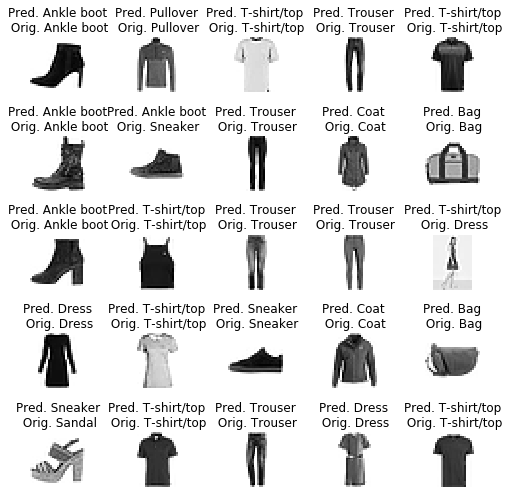

In [11]:
vis_samples(assign_CGM, images,labels)